In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import networkx as nx

plt.style.use('ggplot')
%matplotlib inline

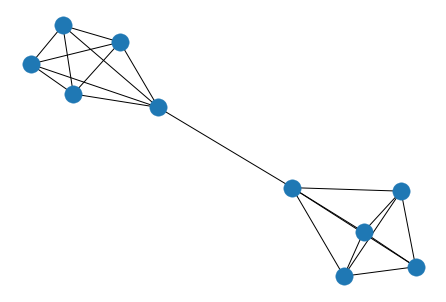

In [92]:
num_each = 10
G = nx.barbell_graph(num_each,0)

# Generate the notes with different number of edges.
mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 8
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2,size=(num_each//2, num_each//2))
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T

mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)
mat[0,-1] = mat[-1,0] = np.random.poisson(8)

# Draw graph
G = nx.from_numpy_array(mat)
nx.draw(G)

In [93]:
model_code= """
data{
        int<lower=1> N;                    // number of nodes
        int X[N,N];                       // adjacency matrix
        int<lower=2> K;                   // number of groups
        vector[K] alpha;                  // prior for dirichlet distribution
        real a;                           // priors on lambda
        real b;
} parameters {
        simplex[K] pi[N];                     // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups
} model{
        for(n in 1:N){
            pi[n] ~ dirichlet(alpha);
        }
        
        for(k in 1:K){
            lambda[k,:] ~ gamma(a,b);
        }
        
        for(i in 1:N){
            for(j in 1:N){
                if (i==j) continue;
                X[i,j] ~ poisson(pi[i]'*lambda*pi[j]);
            }
        }

}
"""

In [94]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f6676b08308113da8f97c49dd77460c NOW.


In [95]:
data = {'X' : mat, 'N' : mat.shape[0], 'K' : 2, 'alpha' : np.ones(2), 'a' : 7.5, 'b' : 1}
fit = sm.sampling(data=data, iter=10000, chains=1)

In [96]:
fit

Inference for Stan model: anon_model_8f6676b08308113da8f97c49dd77460c.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi[1,1]       0.09  1.3e-3   0.07 2.3e-3   0.03   0.08   0.15   0.25   3378    1.0
pi[2,1]       0.02  2.0e-4   0.02 3.7e-4 4.9e-3   0.01   0.02   0.06   7823    1.0
pi[3,1]       0.02  1.8e-4   0.02 4.0e-4 4.5e-3   0.01   0.02   0.06   7809    1.0
pi[4,1]       0.01  1.5e-4   0.01 2.9e-4 3.8e-3 9.1e-3   0.02   0.05   7235    1.0
pi[5,1]       0.02  2.1e-4   0.02 4.1e-4 4.7e-3   0.01   0.02   0.07   7062    1.0
pi[6,1]       0.98  2.4e-4   0.02   0.93   0.97   0.99   0.99    1.0   7123    1.0
pi[7,1]       0.98  2.0e-4   0.02   0.93   0.97   0.99   0.99    1.0   8369    1.0
pi[8,1]       0.98  2.0e-4   0.02   0.93   0.97   0.99   0.99    1.0   8844    1.0
pi[9,1]       0.98  2.2e-4   0.02   0.93   0.97   0.99    1.0  

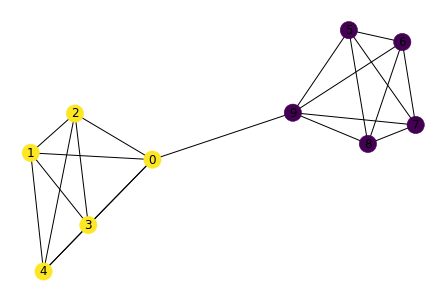

In [97]:
pi = fit.extract()["pi"]
groups = np.argmax(pi[-1],axis = 1)
nx.draw(G,node_color = groups)

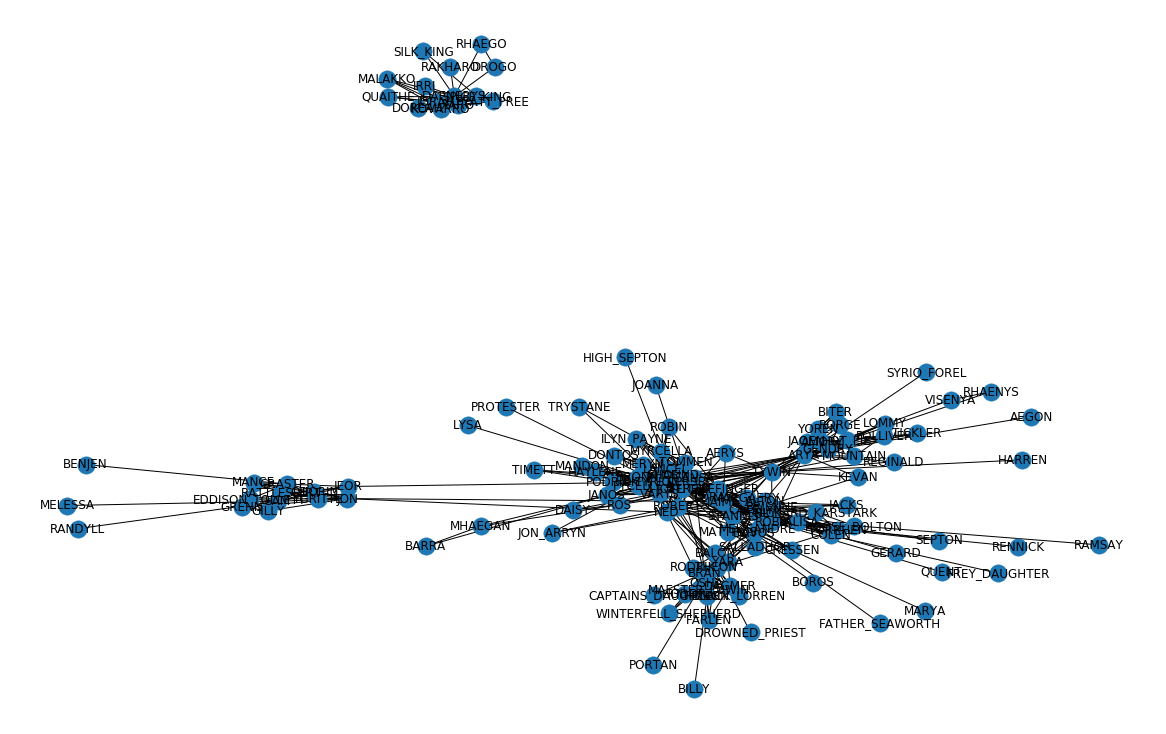

In [100]:
# load nodes and edges from file
nodes = pd.read_csv('../data/got-s2-nodes.csv')
edges = pd.read_csv('../data/got-s2-edges.csv')

# Initialize the graph based on the data from Game of Thrones Season 6
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Conver to numpy to use with STAN
graph = nx.to_numpy_matrix(G, dtype=int)
plt.figure(figsize=(16,10))
nx.draw(G, color='r', label = nodes["Label"], with_labels=True)

In [ ]:
n = graph.shape[0]
k = 5
data = {'X' : graph, 'N' : n, 'K' : k, 'alpha' : np.ones(k), 'a' : 7.5, 'b' : 1}
fit = sm.sampling(data=data, iter=500, chains=1)

In [ ]:
pi = fit.extract()["pi"]

In [ ]:
groups = np.argmax(pi[-3],axis = 1)

In [ ]:
fit

In [ ]:
plt.figure(figsize=(16,16))
nx.draw(G,node_color = groups)

In [84]:
groups

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])